## Tutorial: Defining a new test-time loss and optimizing code.

![TextGrad](https://github.com/vinid/data/blob/master/logo_full.png?raw=true)

An autograd engine -- for textual gradients!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zou-group/TextGrad/blob/main/examples/notebooks/Prompt-Optimization.ipynb)
[![GitHub license](https://img.shields.io/badge/License-MIT-blue.svg)](https://lbesson.mit-license.org/)
[![Arxiv](https://img.shields.io/badge/arXiv-2406.07496-B31B1B.svg)](https://arxiv.org/abs/2406.07496)
[![Documentation Status](https://readthedocs.org/projects/textgrad/badge/?version=latest)](https://textgrad.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/textgrad)](https://pypi.org/project/textgrad/)
[![PyPI](https://img.shields.io/pypi/v/textgrad)](https://pypi.org/project/textgrad/)

**Objectives:**

* In this tutorial, we will do a quick walkthrough around how to define a simple test time loss in TextGrad and optimize a variable of interest.

**Requirements:**

* You need to have an OpenAI API key to run this tutorial. This should be set as an environment variable as OPENAI_API_KEY.

We first define some utilities and a set of test cases.

In [1]:
!pip install textgrad # you might need to restart the notebook after installing textgrad

import textgrad as tg
import random
import time
!pip install anthropic
!pip install litellm --upgrade
from google.colab import userdata
import os
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 126.1 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.76.0
    Uninstalling grpcio-1.76.0:
      Successfully uninstalled grpcio-1.76.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires grpcio>=1.71.2, but you have grpcio 1.67.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 28.0 MB/s eta 0:00:00


### Utilities to run the code, and test cases

In [8]:
# We'll use below utilities to run a python function.
from IPython.core.interactiveshell import InteractiveShell

def run_function_in_interpreter(func_code):
    # raise Exception("This function will run the code returned by GPT-4o. Remove this if you'd like to run the code!")
    interpreter = InteractiveShell.instance()

    interpreter.run_cell(func_code, store_history=False, silent=True)

    func_name = func_code.split("def ")[1].split("(")[0].strip()
    func = interpreter.user_ns[func_name]

    return func


def test_longest_increasing_subsequence(fn):
    nums = [10, 22, 9, 33, 21, 50, 41, 60]
    assert fn(nums) == 5

    nums = [7, 2, 1, 3, 8, 4, 9, 6, 5]
    assert fn(nums) == 4

    nums = [5, 4, 3, 2, 1]
    assert fn(nums) == 1

    nums = [1, 2, 3, 4, 5]
    assert fn(nums) == 5

    nums = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]
    assert fn(nums) == 4

    nums = [10, 9, 2, 5, 3, 7, 101, 18]
    assert fn(nums) == 4

    nums = [0, 8, 4, 12, 2, 10, 6, 14, 1, 9, 5, 13, 3, 11, 7, 15]
    assert fn(nums) == 6

    nums = [7, 7, 7, 7, 7, 7, 7]
    assert fn(nums) == 1

    nums = [20, 25, 47, 35, 56, 68, 98, 101, 212, 301, 415, 500]
    assert fn(nums) == 11

    nums = [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
    assert fn(nums) == 1

    print("All test cases passed!")

## Problem: Improving a code snippet.
We have a simple problem, and an initial solution that does not run quite fast. We first test this solution and look at the wall clock time.

In [9]:
problem_text = """Longest Increasing Subsequence (LIS)

Problem Statement:
Given a sequence of integers, find the length of the longest subsequence that is strictly increasing. A subsequence is a sequence that can be derived from another sequence by deleting some or no elements without changing the order of the remaining elements.

Input:
The input consists of a list of integers representing the sequence.

Output:
The output should be an integer representing the length of the longest increasing subsequence."""

initial_solution = """
def longest_increasing_subsequence(nums):
    n = len(nums)
    dp = [1] * n

    for i in range(1, n):
        for j in range(i):
            if nums[i] > nums[j]:
                dp[i] = max(dp[i], dp[j] + 1)

    max_length = max(dp)
    lis = []

    for i in range(n - 1, -1, -1):
        if dp[i] == max_length:
            lis.append(nums[i])
            max_length -= 1

    return len(lis[::-1])
"""

# Generate a random test case
def generate_random_test_case(size, min_value, max_value):
    return [random.randint(min_value, max_value) for _ in range(size)]

# Test the function with a random test case
size = 10000  # Adjust the size as needed
min_value = 1
max_value = 1000

nums = generate_random_test_case(size, min_value, max_value)


In [10]:
longest_increasing_subsequence = run_function_in_interpreter(initial_solution)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Test Case Size: {size}")
print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

# Test for all test cases
test_longest_increasing_subsequence(longest_increasing_subsequence)

Test Case Size: 10000
Longest Increasing Subsequence Length: 179
Runtime: 7.16657 seconds
All test cases passed!


## TextGrad to optimize code!
Here, we will optimize the code instance. We first define the variables and instantiate the optimizer, then define our loss function, and finally update the code!

In [13]:
from anthropic import Anthropic
llm_engine = tg.get_engine("claude-3-opus-20240229")
tg.set_backward_engine(llm_engine, override=True)

# Code is the variable of interest we want to optimize -- so requires_grad=True
code = tg.Variable(value=initial_solution,
                   requires_grad=True,
                   role_description="code instance to optimize")

# We are not interested in optimizing the problem -- so requires_grad=False
problem = tg.Variable(problem_text,
                      requires_grad=False,
                      role_description="the coding problem")

# Let TGD know to update code!
optimizer = tg.TGD(parameters=[code])

## Defining a loss function with the FormattedLLMCall operation

Here, we define a structured loss function. In particular, we want the following format:

```
{instruction}
Problem: {problem}
Current Code: {code}
```

`FormattedLLMCall` helps us define loss functions like this, while keeping track of the children variables.

In [14]:
# The system prompt that will guide the behavior of the loss function.
loss_system_prompt = "You are a smart language model that evaluates code snippets. You do not solve problems or propose new code snippets, only evaluate existing solutions critically and give very concise feedback."
loss_system_prompt = tg.Variable(loss_system_prompt, requires_grad=False, role_description="system prompt to the loss function")

# The instruction that will be the prefix
instruction = """Think about the problem and the code snippet. Does the code solve the problem? What is the runtime complexity?"""

# The format string and setting up the call
format_string = "{instruction}\nProblem: {{problem}}\nCurrent Code: {{code}}"
format_string = format_string.format(instruction=instruction)

fields = {"problem": None, "code": None}
formatted_llm_call = tg.autograd.FormattedLLMCall(engine=llm_engine,
                                                  format_string=format_string,
                                                  fields=fields,
                                                  system_prompt=loss_system_prompt)

# Finally, the loss function
def loss_fn(problem: tg.Variable, code: tg.Variable) -> tg.Variable:
    inputs = {"problem": problem, "code": code}

    return formatted_llm_call(inputs=inputs,
                              response_role_description=f"evaluation of the {code.get_role_description()}")



In [15]:
# Let's do the forward pass for the loss function.
loss = loss_fn(problem, code)
print(loss.value)

INFO:textgrad:LLMCall function forward


The given code snippet correctly solves the Longest Increasing Subsequence (LIS) problem. It uses dynamic programming to find the length of the longest increasing subsequence.

The code has a time complexity of O(n^2), where n is the length of the input sequence. This is because there are two nested loops iterating over the elements of the sequence. The outer loop runs from index 1 to n-1, and for each element, the inner loop compares it with all the previous elements to find the longest increasing subsequence ending at the current element.

The space complexity of the code is O(n) as it uses an additional array `dp` of size n to store the lengths of the longest increasing subsequences ending at each index.

Overall, the code provides a correct solution to the LIS problem, but it has a quadratic time complexity. There are more efficient algorithms, such as the patience sorting approach or the binary search approach, that can solve the LIS problem in O(n log n) time complexity.


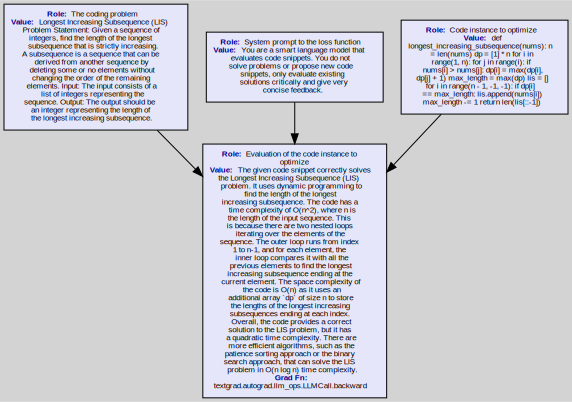

In [16]:
# Let's visualize our computation graph.
loss.generate_graph()

In [17]:
# Let's look at the gradients!
loss.backward()
print(code.gradients)

INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient


{Variable(value=Here are some suggestions to improve the given code for the Longest Increasing Subsequence (LIS) problem, based on the evaluation:

The current code has a time complexity of O(n^2) due to the nested loops. To optimize the runtime, consider using more efficient algorithms such as:

1. Patience Sorting approach: This approach maintains piles of elements and uses binary search to find the appropriate pile for each element. It can solve the LIS problem in O(n log n) time complexity.

2. Binary Search approach: Instead of using nested loops, you can maintain an array to store the smallest ending element of increasing subsequences of different lengths. Use binary search to find the appropriate position to update the array. This approach also achieves O(n log n) time complexity.

Implementing either of these approaches would significantly improve the runtime efficiency of the code.

Additionally, the current code reconstructs the longest increasing subsequence itself, which is

In [18]:
# Let's update the code
optimizer.step()

INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [20]:
import bisect

In [21]:
# Hopefully, we should get much better runtime!
longest_increasing_subsequence = run_function_in_interpreter(code.value)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

test_longest_increasing_subsequence(longest_increasing_subsequence)

Longest Increasing Subsequence Length: 179
Runtime: 0.00264 seconds
All test cases passed!


In [22]:
# Let's do one more iteration
optimizer.zero_grad()
loss = loss_fn(problem, code)
loss.backward()
optimizer.step()

INFO:textgrad:LLMCall function forward
INFO:textgrad:_backward_through_llm prompt
INFO:textgrad:_backward_through_llm gradient
INFO:textgrad:TextualGradientDescent prompt for update
INFO:textgrad:TextualGradientDescent optimizer response
INFO:textgrad:TextualGradientDescent updated text


In [23]:
longest_increasing_subsequence = run_function_in_interpreter(code.value)

start_time = time.time()
lis = longest_increasing_subsequence(nums)
end_time = time.time()

print(f"Longest Increasing Subsequence Length: {lis}")
print(f"Runtime: {end_time - start_time:.5f} seconds")

test_longest_increasing_subsequence(longest_increasing_subsequence)

Longest Increasing Subsequence Length: 179
Runtime: 0.00294 seconds
All test cases passed!


## Optimized code, much faster!

In [24]:
print(code.value)

def longest_increasing_subsequence(nums):
    if not nums:
        return 0

    n = len(nums)
    # dp array stores the elements of the longest increasing subsequence
    lis_elements = [0] * n
    lis_length = 0
    
    for num in nums:
        # Find the appropriate position to insert num using binary search
        index = bisect.bisect_left(lis_elements, num, 0, lis_length)
        lis_elements[index] = num
        
        # If num is greater than all elements in lis_elements, increment length
        if index == lis_length:
            lis_length += 1
    
    return lis_length
